# Crossover in P2 Problem

## Problem P2 — Discrete Coverage with Mobility


In [100]:
import random
import math

def stochastic_reachability_mask(
    candidates: list[tuple[float, float]],
    sink: tuple[float, float],
    radius: float,
    rng: random.Random | None = None,
) -> list[int]:
    if rng is None:
        rng = random.Random()

    n = len(candidates)

    # ------------------------------------------------------------
    # State sets (indices)
    # ------------------------------------------------------------
    FREE = set(range(n))
    SELECTED = set()
    DISCARDED = set()

    # Frontier (active expansion nodes)
    frontier = set()

    # ------------------------------------------------------------
    # Distance helpers
    # ------------------------------------------------------------
    def dist_sink(i: int) -> float:
        x1, y1 = sink
        x2, y2 = candidates[i]
        return math.hypot(x1 - x2, y1 - y2)
    
    def dist(i: int, j: int) -> float:
        x1, y1 = candidates[i]
        x2, y2 = candidates[j]
        return math.hypot(x1 - x2, y1 - y2)

    # ------------------------------------------------------------
    # Initial expansion from sink (virtual root)
    # ------------------------------------------------------------
    reachable_from_sink = [
        i for i in FREE
        if dist_sink(i) < radius
    ]

    if reachable_from_sink:
        c = rng.randint(1, len(reachable_from_sink))
        chosen = set(rng.sample(reachable_from_sink, c))
        rejected = set(reachable_from_sink) - chosen

        SELECTED.update(chosen)
        frontier.update(chosen)

        FREE.difference_update(chosen)
        FREE.difference_update(rejected)
        DISCARDED.update(rejected)

    # ------------------------------------------------------------
    # Main growth loop (from selected candidates)
    # ------------------------------------------------------------
    while frontier and FREE:
        u = frontier.pop()

        reachable = [
            v for v in FREE
            if dist(u, v) < radius
        ]

        if not reachable:
            continue

        c = rng.randint(1, len(reachable))
        chosen = set(rng.sample(reachable, c))
        rejected = set(reachable) - chosen

        SELECTED.update(chosen)
        frontier.update(chosen)

        FREE.difference_update(chosen)
        FREE.difference_update(rejected)
        DISCARDED.update(rejected)

    # ------------------------------------------------------------
    # Build binary mask
    # ------------------------------------------------------------
    mask = [1 if i in SELECTED else 0 for i in range(n)]
    return mask

In [101]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

def plot_network(
    points: list[tuple[float, float]],
    region: tuple[float, float, float, float],
    radius: float
    ) -> None:

    _, ax = plt.subplots(figsize=(10, 8))

    ax.set_xlim(region[0], region[2])
    ax.set_ylim(region[1], region[3])
    ax.set_aspect("equal")
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.set_title(
        f"Rede com {len(points)} nós "
        f"(raio comunicação = {radius}"
    )

    ax.add_patch(
        plt.Rectangle(
            (region[0], region[1]),
            region[2] - region[0],
            region[3] - region[1],
            fill=False,
            linestyle="--",
            edgecolor="red",
            linewidth=1,
        )
    )

    # Communication edges
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            d = np.hypot(points[i][0] - points[j][0],
                         points[i][1] - points[j][1])
            if d <= radius:
                ax.plot(
                    [points[i][0], points[j][0]],
                    [points[i][1], points[j][1]],
                    color="#EE0A0A",
                    linewidth=1,
                    alpha=0.7,
                )

    # Communication disks
    for (x, y) in points:
        ax.add_patch(
            Circle(
                (x, y),
                radius,
                facecolor="#4ECDC4",   # verde-água
                edgecolor="green",
                alpha=0.35,
                linewidth=1.0,
            )
        )

    # Nodes (markers)
    for i, (x, y) in enumerate(points):
        ax.plot(x, y, "o", markersize=8, color="gray")
        ax.text(x, y, str(i+1), color="black",
                ha="center", va="center", fontsize=8)

    plt.show()

In [102]:
from collections import deque
import math

def repair_connectivity_to_sink(
    candidates: list[tuple[float, float]],
    mask: list[int],
    sink: tuple[float, float],
    radius: float,
) -> tuple[bool, list[int]]:
    """
    Repairs a binary mask by connecting all components to the sink
    using minimal (heuristic) node activations.

    Parameters
    ----------
    candidates : list[(float, float)]
        Candidate positions Q.
    mask : list[int]
        Binary mask (may be disconnected).
    sink : (float, float)
        Sink position (must be active or will be activated).
    radius : float
        Reachability radius.

    Returns
    -------
    repaired_mask : tuple[bool, list[int]]
        Error flag and repaired binary mask (globally connected to sink).
    """

    n = len(candidates)
    mask = mask[:]  # copy

    # ------------------------------------------------------------
    # Distance helpers
    # ------------------------------------------------------------
    def dist(i: int, j: int) -> float:
        x1, y1 = candidates[i]
        x2, y2 = candidates[j]
        return math.hypot(x1 - x2, y1 - y2)

    def dist_sink(i: int) -> float:
        x1, y1 = sink
        x2, y2 = candidates[i]
        return math.hypot(x1 - x2, y1 - y2)

    # ------------------------------------------------------------
    # Build full reachability graph over candidates
    # ------------------------------------------------------------
    adj = [[] for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            if dist(i, j) <= radius:
                adj[i].append(j)
                adj[j].append(i)

    # ------------------------------------------------------------
    # Active connected components (ignoring sink)
    # ------------------------------------------------------------
    def active_components():
        visited = set()
        components = []

        for i in range(n):
            if mask[i] == 1 and i not in visited:
                comp = set()
                queue = deque([i])
                visited.add(i)

                while queue:
                    u = queue.popleft()
                    comp.add(u)
                    for v in adj[u]:
                        if mask[v] == 1 and v not in visited:
                            visited.add(v)
                            queue.append(v)

                components.append(comp)

        return components

    # ------------------------------------------------------------
    # Main repair loop
    # ------------------------------------------------------------
    while True:
        components = active_components()
        if not components:
            break

        # --------------------------------------------------------
        # Define sink component: active nodes reachable from sink
        # --------------------------------------------------------
        sink_comp = {
            i for i in range(n)
            if mask[i] == 1 and dist_sink(i) <= radius
        }

        # If no active node reaches sink, connect the closest one
        if not sink_comp:
            closest = min(
                (i for i in range(n) if mask[i] == 1),
                key=lambda i: dist_sink(i)
            )
            mask[closest] = 1
            sink_comp.add(closest)

        # If all components already intersect sink_comp, done
        if all(comp & sink_comp for comp in components):
            break

        # Pick one disconnected component
        other_comp = next(comp for comp in components if not (comp & sink_comp))

        # --------------------------------------------------------
        # BFS from sink_comp to other_comp on full graph
        # --------------------------------------------------------
        queue = deque()
        parent = {}

        # Virtual BFS start from all nodes in sink_comp
        for u in sink_comp:
            queue.append(u)
            parent[u] = None

        target = None

        while queue and target is None:
            u = queue.popleft()
            for v in adj[u]:
                if v not in parent:
                    parent[v] = u
                    if v in other_comp:
                        target = v
                        break
                    queue.append(v)

        if target is None:
            # Cannot repair connectivity: unreachable component"
            return True, []

        # --------------------------------------------------------
        # Activate path nodes
        # --------------------------------------------------------
        cur = target
        while cur is not None:
            mask[cur] = 1
            cur = parent[cur]

    return False, mask

In [103]:
REGION = [-150, -150, 150, 150]  # xmin, ymin, xmax, ymax
SINK = (0.0, 0.0)
RADIUS = 50
Q = [
    (-29.0, 32.0),
    (-11.0, -45.5),
    (27.0, 39.0),
    (-74.47885710671174, 32.41437154400245),
    (-102.0, -21.0),
    (-91.0, -59.0),
    (24.144027024094726, -56.0352263042327),
    (-67.69032968, 142.50112841),
    (67.8707393, -62.36414514),
    (-57.68472299, -124.83566249),
    (-78.04674724, -113.66712065),
    (146.14800398, -7.3791121),
    (106.13805794, -3.29433074),
    (69.40421416, -83.26720991),
    (-95.96047696, 15.70418304),
    (-54.06035545, 143.00029275),
    (-57.31450534, -76.97786151),
    (-149.35979434, -95.9767557),
    (-92.69040595, 46.93918866),
    (16.41848712, -105.77423696),
    (74.0, 29.0),
    (102.0, -12.0),
    (114.0, -33.0),
    (87.0, 44.0),
    (-87.71983361, -97.07597746),
    (-97.54501379, -89.63587885),
    (102.33307764, -123.15145324),
    (39.91740445, 47.22574766),
    (28.00192767, 101.77950592),
    (-35.53333098, 109.99891708),
    (35.01281907, 59.08970132),
    (-6.41825968, 133.17764391),
    (-17.91739867, -60.38480873),
    (-49.03573903173938, -69.70902258243518),
    (-74.95386805, -66.48682231),
    (68.20810713, 60.03277826),
    (-67.0985295, -136.09832413),
    (-115.49312114, -86.33587195),
    (-58.75086876, -94.75458927),
    (89.8470229, -46.92998482),
    (-135.23590677, -24.95078446),
    (108.64679377, 93.55443944),
]

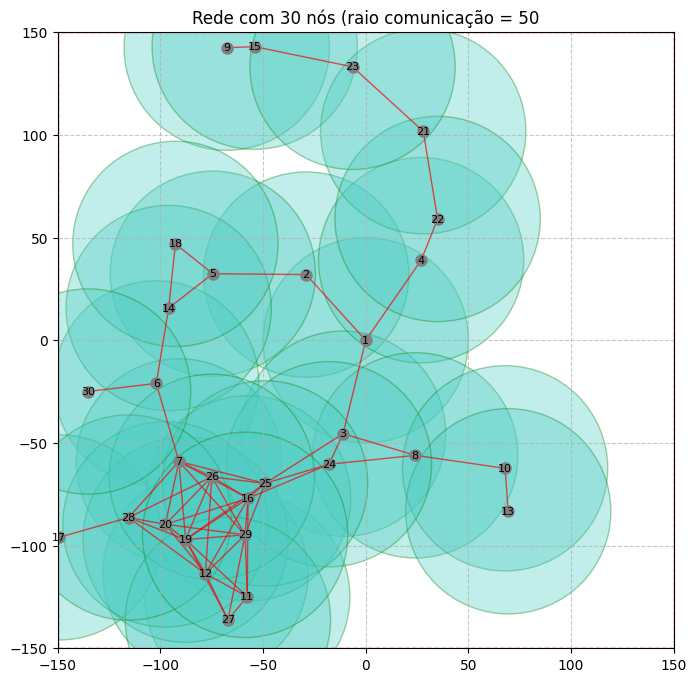

In [104]:
mask = stochastic_reachability_mask(Q, SINK, RADIUS)
points: list[tuple[float,float]] = []

for i, q in enumerate(Q):
    if mask[i]==1:
        points.append(q)
        
plot_network([SINK] + points, REGION, RADIUS)
P1 = mask

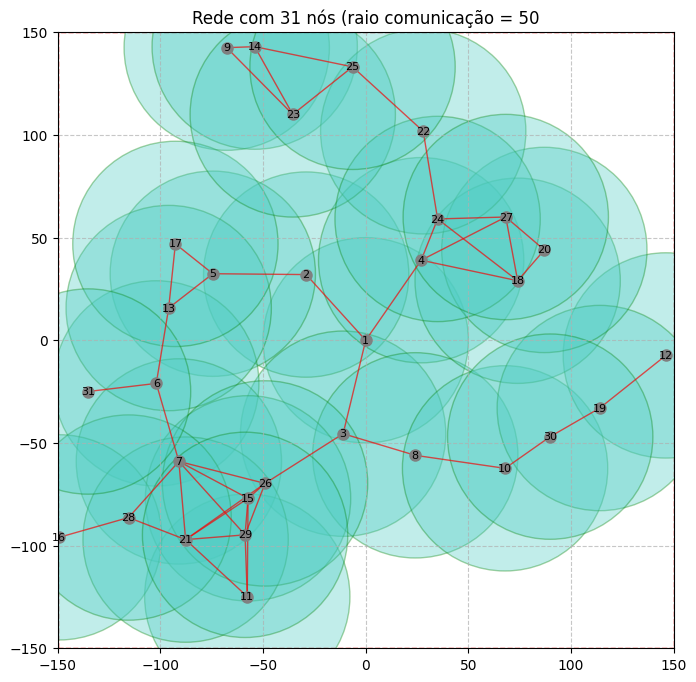

In [105]:
mask = stochastic_reachability_mask(Q, SINK, RADIUS)
points: list[tuple[float,float]] = []

for i, q in enumerate(Q):
    if mask[i]==1:
        points.append(q)
        
plot_network([SINK] + points, REGION, RADIUS)
P2 = mask

In [106]:
import random

def uniform_crossover_mask(a: list[int], b: list[int]) -> tuple[list[int], list[int]]:
    """Uniform crossover for binary masks."""
    assert len(a) == len(b)
    c1, c2 = a[:], b[:]
    for i in range(len(a)):
        if random.random() < 0.5:
            c1[i], c2[i] = c2[i], c1[i]
    return c1, c2

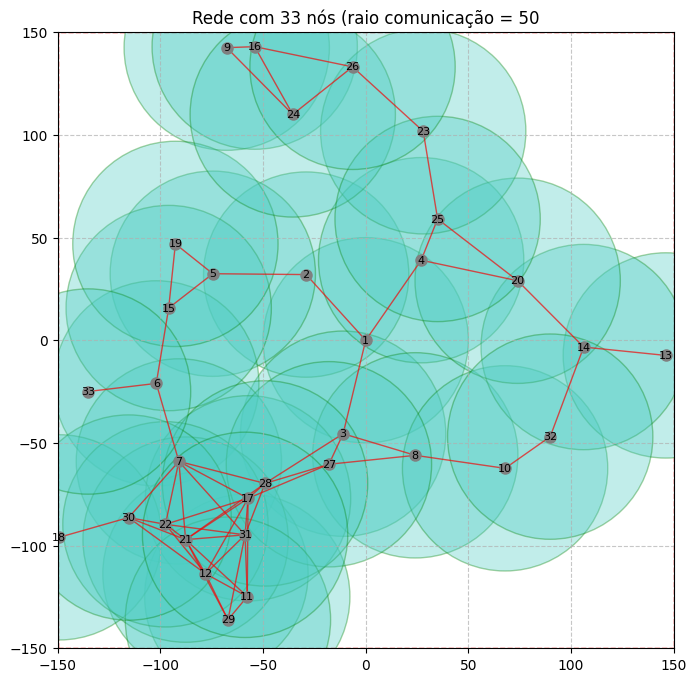

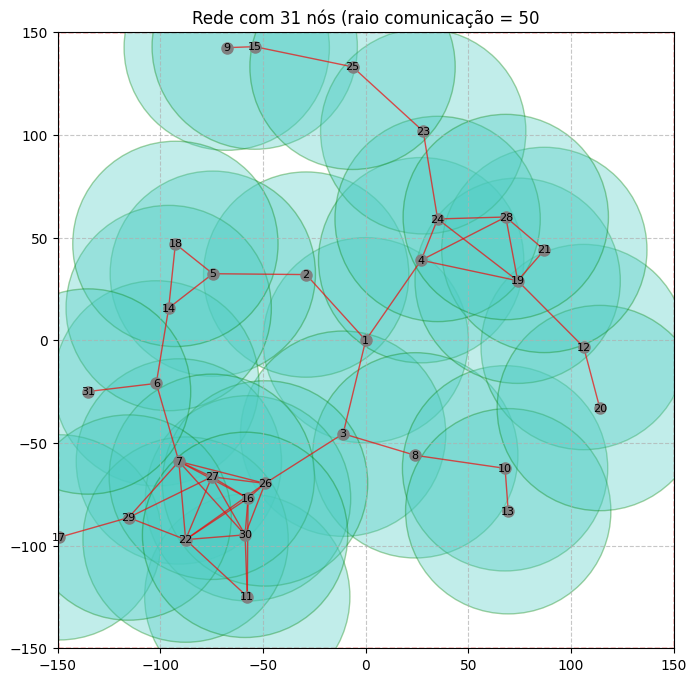

P1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
P2: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0]
C1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0]
C2: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]



In [108]:
c1, c2 = uniform_crossover_mask(P1, P2)
        
err, c1 = repair_connectivity_to_sink(Q, c1, SINK, RADIUS)
if err:
    print(f"Repair failed. c1 crossover.")
    c1 = P1
err, c2 = repair_connectivity_to_sink(Q, c2, SINK, RADIUS)
if err:
    print(f"Repair failed. c2 crossover.")
    c2 = P2
    
points.clear()
for i, q in enumerate(Q):
    if c1[i]==1:
        points.append(q)
        
plot_network([SINK] + points, REGION, RADIUS)

points.clear()
for i, q in enumerate(Q):
    if c2[i]==1:
        points.append(q)
        
plot_network([SINK] + points, REGION, RADIUS)

print(f"P1: {P1}\nP2: {P2}\nC1: {c1}\nC2: {c2}\n")